In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2, imageio
import copy, random, os, subprocess, datetime 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, regularizers, preprocessing
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()    

/opt/conda/lib/python3.7/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:28: Depreca

In [2]:
BUCKET = 'gs://etsuji-car-racing-v2'
os.environ['BUCKET'] = BUCKET
!gsutil ls $BUCKET

gs://etsuji-car-racing-v2/model04/
gs://etsuji-car-racing-v2/model05/
gs://etsuji-car-racing-v2/model06/
gs://etsuji-car-racing-v2/model07/


In [3]:
class ApplyL1Weight(layers.Layer):
    def __init__(self, l1=0.01, **kwargs):
        self.filter_shape = None
        self.l1 = l1
        super(ApplyL1Weight, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.kernel = self.add_weight(name='weights', shape=[input_shape[3]],
                                      regularizer=regularizers.L1(self.l1))
        self.filter_shape = input_shape

    def get_config(self):
        config = super().get_config()
        config.update({
            'l1': self.l1,
        })
        return config
    
    def call(self, inputs, **kwargs):
        return inputs * self.kernel
    
class QValue:
    def __init__(self):
        self.model = None
        self.name = None
        self.checkpoint = None

    def get_action(self, state):
        states = []
        actions = []
        for a in range(5):
            states.append(np.array(state))
            action_onehot = np.zeros(5)
            action_onehot[a] = 1
            actions.append(action_onehot)
  
        q_values = self.model.predict([np.array(states), np.array(actions)])
        optimal_action = np.argmax(q_values)
        return optimal_action, q_values[optimal_action][0]

In [4]:
def join_frames(o0, o1, o2):
    gray_image0 = cv2.cvtColor(cv2.resize(o0, (48, 48)), cv2.COLOR_RGB2GRAY)
    gray_image1 = cv2.cvtColor(cv2.resize(o1, (48, 48)), cv2.COLOR_RGB2GRAY)
    gray_image2 = cv2.cvtColor(cv2.resize(o2, (48, 48)), cv2.COLOR_RGB2GRAY)
    
    return np.array(
        [gray_image0.transpose(),
         gray_image1.transpose(),
         gray_image2.transpose()]).transpose()

In [5]:
def get_weighted_filters(q_value, target_image, draw=True):
    o0, o1, o2 = target_image
    target_image = join_frames(o0, o1, o2)
    a, _ = q_value.get_action(target_image)
    action_onehot = np.zeros(5)
    action_onehot[a] = 1
    
    model = q_value.model
    pred_output = model.output # Q Value for a specific action
    last_conv_layer = model.get_layer('weighted_filters')    
    ws = last_conv_layer.get_weights()[0]
    get_vals = K.function([model.input],
                          [last_conv_layer.output[0]])
    conv_layer_output_val = get_vals([np.array([target_image]),
                                      np.array([action_onehot])])[0]

    if draw:
        fig = plt.figure(figsize=(20, 12))
        for i in range(last_conv_layer.output.shape[-1]):
            subplot = fig.add_subplot(8, 16, i+1)
            subplot.set_xticks([])
            subplot.set_yticks([])
            subplot.imshow(conv_layer_output_val[:, :, i], cmap=plt.cm.gray_r)
            subplot.title.set_text('{:0.2f}'.format(abs(ws[i]) * 100))
    else:
        return conv_layer_output_val, ws

In [6]:
def get_heatmap(q_value, target_image):
    conv_layer_output_val, ws = get_weighted_filters(q_value, target_image, draw=False)
    original = target_image[-1]

    heatmap = np.zeros([96 // 8, 96 // 8])
    for i in range(conv_layer_output_val.shape[-1]):
        heatmap += conv_layer_output_val[:, :, i] * ws[i]
    h_mean = heatmap.mean()
    h_std  = np.std(heatmap)
    heatmap = (heatmap - h_mean) / h_std
    heatmap = np.clip(heatmap, a_min=-1, a_max=1)
    heatmap = (heatmap + 1) / 2

    heatmap = np.uint8(255 * cv2.resize(heatmap, (96, 96)))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.35 + \
                       cv2.cvtColor(original, cv2.COLOR_RGB2BGR) * 0.65

    cv2.imwrite('/tmp/result.jpg', superimposed_img)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = preprocessing.image.load_img('/tmp/result.jpg')

    return original, heatmap, superimposed_img    

In [89]:
def create_gif(q_value, epsilon=0):
    env = gym.make("CarRacing-v2", continuous=False)
    o0 = env.reset()
    o1 = copy.deepcopy(o0)
    o2 = copy.deepcopy(o0)
    done = 0
    total_r = 0
    c = 0
    frames = []
    raw_frames = []

    while not done:
        if np.random.random() < epsilon:
            a = np.random.randint(5)
        else:
            a, _ = q_value.get_action(join_frames(o0, o1, o2))          
        o_new, r, done, i = env.step(a)
        total_r += r
        o0, o1, o2 = o1, o2, o_new 
        c += 1
        frame = env.render('rgb_array')

        raw_frames.append([o0, o1, o2])
        frames.append(frame)

        if c % 30 == 0:
            print('{}:{}'.format(a, int(total_r)), end=', ')

    print('{}:{}'.format(a, int(total_r)))
    now = datetime.datetime.now()
    imageio.mimsave('car-racing-v2-{}-{:05d}-{}-{}.gif'.format(
        q_value.name, int(q_value.checkpoint), int(total_r), now.strftime('%Y%m%d-%H%M%S')),
                    frames, 'GIF' , **{'duration': 1.0/50.0})
    return frames, raw_frames, total_r

In [92]:
def create_overlay_gif(q_value, frames, raw_frames, total_r):
    frames_overlay = []
    c = 0
    for frame, raw_frame in zip(frames, raw_frames):
        _, heatmap, _ = get_heatmap(q_value, raw_frame)
        superimposed = np.uint8(cv2.resize(heatmap, (600, 400)) * 0.35 + frame * 0.65)
        frames_overlay.append(superimposed)
        c += 1
        if c % 10 == 0:
            print('.', end='')

    print('')
    now = datetime.datetime.now()
    imageio.mimsave('car-racing-v2-{}-{:05d}-{}-{}-overlay.gif'.format(
        q_value.name, int(q_value.checkpoint), int(total_r), now.strftime('%Y%m%d-%H%M%S')),
                    frames_overlay, 'GIF' , **{'duration': 1.0/50.0})

In [9]:
def show_frames(q_value, target_images):
    num = len(target_images)
    fig = plt.figure(figsize=(11, num * 3))
    c = 1
    for i in range(len(target_images)):
        original, heatmap, superimposed = get_heatmap(q_value, target_images[i])
        subplot = fig.add_subplot(num, 4, c)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(original)
        c += 1
        gray_image = cv2.cvtColor(cv2.resize(original, (96//2, 96//2)),
                                  cv2.COLOR_RGB2GRAY)
        subplot = fig.add_subplot(num, 4, c)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(gray_image, cmap=plt.cm.gray)
        c += 1
        subplot = fig.add_subplot(num, 4, c)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(heatmap)
        c += 1
        subplot = fig.add_subplot(num, 4, c)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(superimposed)
        c += 1

In [10]:
def load_model(q_value, checkpoint, model='model01'):
    BUCKET = 'gs://etsuji-car-racing-v2'
    filename = 'car-racing-v2-{}-{}.hd5'.format(checkpoint, model)
    if not os.path.isfile(filename):
        subprocess.run(['gsutil', 'cp', '{}/{}/{}'.format(BUCKET, model, filename), './'])
    
    print('load model {}'.format(filename))

    q_value.model = models.load_model(filename, custom_objects={"ApplyL1Weight": ApplyL1Weight})
    q_value.name = model
    q_value.checkpoint = checkpoint

In [81]:
q_value = QValue()
load_model(q_value, 567, 'model06')

Copying gs://etsuji-car-racing-v2/model06/car-racing-v2-567-model06.hd5...
- [1 files][ 40.2 MiB/ 40.2 MiB]                                                
Operation completed over 1 objects/40.2 MiB.                                     


load model car-racing-v2-567-model06.hd5


In [94]:
frames, raw_frames, total_r = create_gif(q_value)

0:12, 0:25, 2:42, 2:67, 2:92, 3:117, 0:138, 0:163, 0:188, 0:213, 3:237, 3:266, 2:291, 0:320, 2:345, 3:370, 0:395, 1:424, 3:448, 1:477, 0:510, 2:539, 0:572, 0:601, 1:634, 2:667, 3:703, 0:736, 0:765, 0:798, 0:827, 0:848, 0:845, 2:844


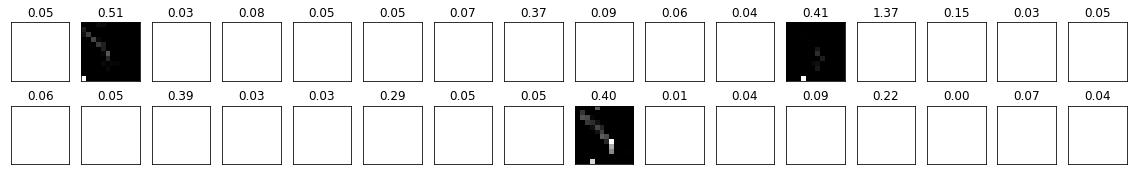

In [99]:
get_weighted_filters(q_value, raw_frames[900])

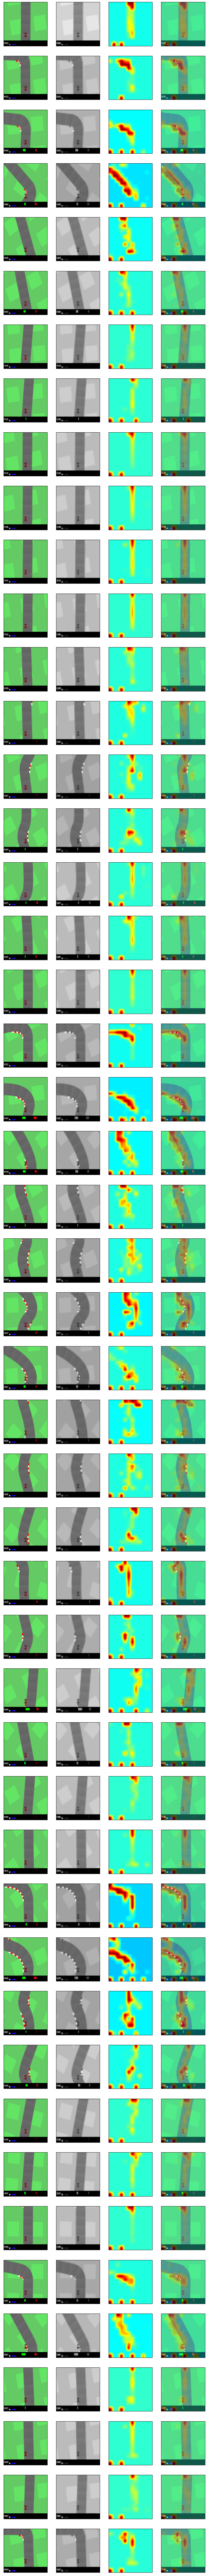

In [97]:
show_frames(q_value, raw_frames[50:1000:20])

In [98]:
%%time
create_overlay_gif(q_value, frames, raw_frames, total_r)

....................................................................................................
CPU times: user 11min 44s, sys: 3.63 s, total: 11min 47s
Wall time: 11min 36s
